In [1]:
import sys
import os
import numpy as np
import re
# import psycopg2 as pg
# import pandas as pd
# import pandas.io.sql as psql
# import getpass
import matplotlib as mpl
# import argparse
# import glob
# import traceback
import hashlib
import math
import collections
import functools
import datetime
from sklearn.externals import joblib
import pickle

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

# import event_processing_v3
# import event_processing_v4
# import postgresql_v3_event_storage
# import dataset_query_functions_v3

# import tool.acqconv
# from data_analysis_utils import *
# from data_analysis_utils_dataframes import *
# import supervised_classification as supc 
# from utility_funtions import key_vals2val_keys

import event_reading


Welcome to JupyROOT 6.13/02


In [100]:
recreate_plots = True
recreate_pickles = False

In [93]:
files_dir_abspath = '/home/spbproc/SPBDATA_flight'

data_snippets_dir = 'trigger_rate_figures_hw'
os.makedirs(data_snippets_dir, exist_ok=True)
os.makedirs(os.path.join(data_snippets_dir, 'figures'), exist_ok=True)

In [94]:
def filter_func(f,d): 
    r = os.path.splitext(f)[1] == ".root" and "ACQUISITION" in os.path.basename(f) and re.search(r'SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170(42[4-9]|430|5\d+)$',d) is not None
    return r
processed_files = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(files_dir_abspath) for f in fn if filter_func(f,dp)])

In [95]:
processed_files_subset = processed_files #[60:64]

In [96]:
processed_files_subset

['/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150143-001.001--CHECK.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150228-001.001--LONG.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150228-002.001--LONG.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150228-003.001--LONG.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150228-004.001--LONG.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150228-005.001--LONG.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-172343-001.001--CHECK.root',
 '/home/spbproc/SPBDATA_f

In [152]:
processed_files_subset[-20:-1]

['/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-144913-001.001--CHECK.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-151420-001.001--CHECK.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170503/allpackets-SPBEUSO-ACQUISITION-20170503-085415-001.001--CHECK.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170503/allpackets-SPBEUSO-ACQUISITION-20170503-085728-001.001--CHECK.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170503/allpackets-SPBEUSO-ACQUISITION-20170503-090032-001.001--CHECK.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170503/allpackets-SPBEUSO-ACQUISITION-20170503-111308-001.001--CHECK.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170503/allpackets-SPBEUSO-ACQUISITION-20170503-122552-001.001--CHECK.root',
 '/home/spbproc/SPBD

In [97]:
print('Num processed files', len(processed_files_subset))

Num processed files 1087


In [151]:
len(set([os.path.basename(p) for p in processed_files_subset]))

1087

In [150]:
len(set([os.path.basename(p) for p in processed_files_subset if '20170424' not in p]))

1075

In [98]:
processed_files_hash = hashlib.md5(pickle.dumps(processed_files_subset, protocol=0)).hexdigest()

In [99]:
processed_files_hash

'0359ed3b8091809b70ce45f5e2cd3f40'

In [124]:
trigger_num_per_step_list_pathname = \
    os.path.join(data_snippets_dir, '{}_v1_trigger_num_per_step.pkl'.format(processed_files_hash))
trigger_datetime_steps_list_pathname = \
    os.path.join(data_snippets_dir, '{}_v1_trigger_datetime_steps.pkl'.format(processed_files_hash))
trigger_p_r_steps_list_pathname = \
    os.path.join(data_snippets_dir, '{}_v1_trigger_p_r_steps.pkl'.format(processed_files_hash))

print(trigger_num_per_step_list_pathname, os.path.exists(trigger_num_per_step_list_pathname))
print(trigger_datetime_steps_list_pathname, os.path.exists(trigger_datetime_steps_list_pathname))

status_every_n = 1

if not os.path.exists(trigger_num_per_step_list_pathname) or not os.path.exists(trigger_datetime_steps_list_pathname) \
        or recreate_pickles: # not os.path.exists(trigger_p_r_steps_list) 
    
    trigger_num_per_step_list = [0]
    trigger_datetime_steps_list = []
    trigger_p_r_steps_list = []
    datetime_step_high = None 

    last_p_r = None

    ii = 0
    for j, infile in enumerate(processed_files_subset):

        print('{:>4d} / {:<4d} {}'.format(j+1, len(processed_files_subset), infile))

        with event_reading.AcqL1EventReader(
                infile, None, load_pdm_event_summary=True, parse_pdm_event_summary=False) as aer:
            
            for i, gtu_pdm_data in enumerate(aer.iter_gtu_pdm_data()):
                if np.count_nonzero(aer._tevent_event_trig_counts) > 0:
                    p_r = (aer._tevent_event_p_val.item(), aer._tevent_event_r_val.item())
                    
                    if last_p_r is None and datetime_step_high is None:
                        last_p_r = p_r
                        trigger_p_r_steps_list.append(p_r)

                        datetime_step_high = gtu_pdm_data.gps_datetime + datetime.timedelta(seconds=1)   # gtu_datetime replacet by gps_datetime
                        
                        print('  {:<5d}  {}  INIT'.format(ii, datetime_step_high))
                        print('  {}  P={} R={}'.format(' '*5, *p_r))

                    if gtu_pdm_data.gps_datetime >= datetime_step_high or last_p_r != p_r:
                        
                        prev_p_r = None
                        
                        if last_p_r != p_r:
                            prev_p_r = last_p_r
                            last_p_r = p_r
                            
                        while gtu_pdm_data.gps_datetime >= datetime_step_high:
                            datetime_step_high += datetime.timedelta(seconds=1)
                        
                        if ii % status_every_n == 0 or prev_p_r is not None:
                            print('  {:<5d}  {}'.format(ii, datetime_step_high))
                            if prev_p_r is not None:
                                print('  {}  P={} R={} -> P={} R={}'.format(' '*5, *prev_p_r, *p_r))
                            else:
                                print('  {}  P={} R={}'.format(' '*5, *p_r))

                        trigger_datetime_steps_list.append(datetime_step_high - datetime.timedelta(seconds=1))
                        trigger_num_per_step_list.append(0)
                        trigger_p_r_steps_list.append(p_r)
                        ii += 1

                    print('  {:<5d}     {}  <  {}'.format(ii, gtu_pdm_data.gps_datetime, datetime_step_high))
                    trigger_num_per_step_list[ii] += 1
                # endif
            # endfor
        # endwith
    # endfor
    
    if datetime_step_high is not None:
        trigger_datetime_steps_list.append(datetime_step_high - datetime.timedelta(seconds=1))

#     joblib.dump(trigger_num_per_step_list, trigger_num_per_step_list_pathname)
#     joblib.dump(trigger_datetime_steps_list, trigger_datetime_steps_list_pathname)
#     joblib.dump(trigger_p_r_steps_list, trigger_p_r_steps_list_pathname)

else:
    
    trigger_num_per_step_list = joblib.load(trigger_num_per_step_list_pathname)
    trigger_datetime_steps_list = joblib.load(trigger_datetime_steps_list_pathname)
    trigger_p_r_steps_list = joblib.load(trigger_p_r_steps_list_pathname)

trigger_rate_figures_hw/0359ed3b8091809b70ce45f5e2cd3f40_v1_trigger_num_per_step.pkl True
trigger_rate_figures_hw/0359ed3b8091809b70ce45f5e2cd3f40_v1_trigger_datetime_steps.pkl True


In [127]:
np.array(trigger_p_r_steps_list).max()

4

In [128]:
len(trigger_datetime_steps_list)

53130

In [129]:
len(trigger_num_per_step_list)

53130

In [130]:
min(trigger_num_per_step_list)

1

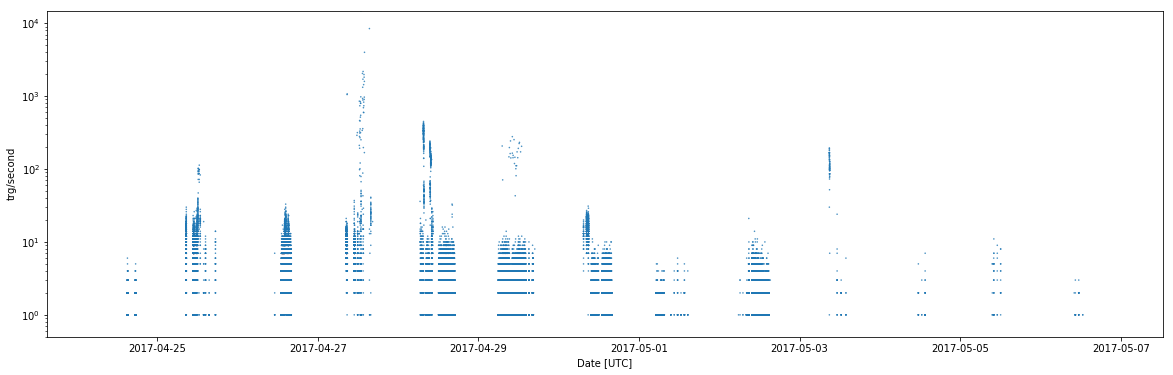

In [131]:
plt_xlim = (np.min(trigger_datetime_steps_list) - datetime.timedelta(days=1), 
             np.max(trigger_datetime_steps_list) + datetime.timedelta(days=1))

plt.figure(figsize=(20, 6))
plt.scatter(trigger_datetime_steps_list, 
            trigger_num_per_step_list, 
            s=10, alpha=.8,
#             alpha=.01,
            cmap=plt.get_cmap('plasma'),
            marker='.', edgecolors='none',
            label='Num triggers per second'
           )
plt.xlim(*plt_xlim)
plt.yscale('log')
# plt.ylim(1e-1, np.max(trigger_num_per_step)+10)
plt.ylim(0.5, np.max(trigger_num_per_step_list)+10)
plt.xlabel('Date [UTC]')
plt.ylabel('trg/second')

plt.show()

In [132]:
trigger_datetime_steps_list[:10]

[datetime.datetime(2017, 4, 24, 15, 1, 50),
 datetime.datetime(2017, 4, 24, 15, 1, 53),
 datetime.datetime(2017, 4, 24, 15, 1, 54),
 datetime.datetime(2017, 4, 24, 15, 2, 4),
 datetime.datetime(2017, 4, 24, 15, 2, 9),
 datetime.datetime(2017, 4, 24, 15, 2, 10),
 datetime.datetime(2017, 4, 24, 15, 2, 11),
 datetime.datetime(2017, 4, 24, 15, 2, 16),
 datetime.datetime(2017, 4, 24, 15, 2, 20),
 datetime.datetime(2017, 4, 24, 15, 2, 21)]

In [133]:
step_timedelta = datetime.timedelta(seconds=120)

avg_trigger_num_per_step_list = []
avg_trigger_datetime_steps_list = []
avg_trigger_p_r_steps_list = []

datetime_step_high = trigger_datetime_steps_list[0] + step_timedelta

last_p_r = trigger_p_r_steps_list[0]
last_datetime_step_start = trigger_datetime_steps_list[0]
sum_trigger_num_per_step = 0


for i, (cur_trigger_num_per_step, cur_trigger_datetime_step, cur_trigger_p_r_step) in \
        enumerate(zip(trigger_num_per_step_list, trigger_datetime_steps_list, trigger_p_r_steps_list)):
    
#     if i > 9600:
#         print('{:<5d} ; ({:3}, {:20}, {:10}) ; {:20} ; {:20}'.format(
#             i, cur_trigger_num_per_step, str(cur_trigger_datetime_step), str(cur_trigger_p_r_step), 
#             str(datetime_step_high), str(last_datetime_step_start)))
    
    
#     if i > 9700:
#         break
    
    if cur_trigger_datetime_step >= datetime_step_high or last_p_r != cur_trigger_p_r_step:
        
#         if i > 9600:
#             print('   !!!!!!!!')
        
        avg_trigger_num_per_step_list.append(sum_trigger_num_per_step / (datetime_step_high - last_datetime_step_start).total_seconds())
        avg_trigger_datetime_steps_list.append(last_datetime_step_start)
        avg_trigger_p_r_steps_list.append(last_p_r)

        if last_p_r != cur_trigger_p_r_step:
            last_p_r = cur_trigger_p_r_step
            
        last_datetime_step_start = cur_trigger_datetime_step # was datetime_step_high
            
        while cur_trigger_datetime_step >= datetime_step_high:
            datetime_step_high += step_timedelta
        
        sum_trigger_num_per_step = 0

    # endif
    
#     print('  {:<5d}     {}  <  {}'.format(ii, gtu_pdm_data.gtu_datetime, datetime_step_high))

    sum_trigger_num_per_step += cur_trigger_num_per_step

    #trigger_num_per_step[ii] += 1
    
# endfor

avg_trigger_num_per_step_list.append(sum_trigger_num_per_step / (datetime_step_high - last_datetime_step_start).total_seconds())
avg_trigger_datetime_steps_list.append(last_datetime_step_start)
avg_trigger_p_r_steps_list.append(last_p_r)


In [134]:
print(len(avg_trigger_num_per_step_list))
print(len(avg_trigger_datetime_steps_list))
print(len(avg_trigger_p_r_steps_list))

1017
1017
1017


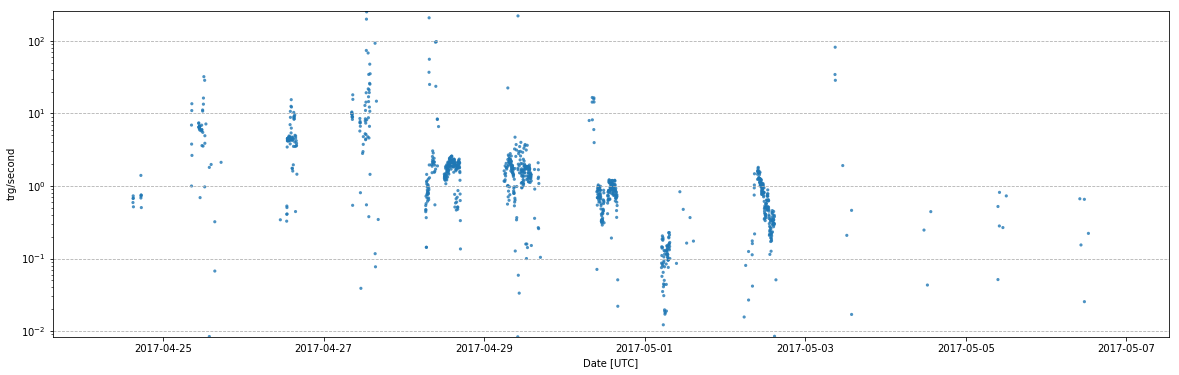

In [137]:
plt_xlim = (np.min(avg_trigger_datetime_steps_list) - datetime.timedelta(days=1), 
             np.max(avg_trigger_datetime_steps_list) + datetime.timedelta(days=1))

plt.figure(figsize=(20, 6))
plt.scatter(avg_trigger_datetime_steps_list, 
            avg_trigger_num_per_step_list, 
            s=10, alpha=.8,
#             alpha=.01,
            cmap=plt.get_cmap('plasma'),
            marker='o', edgecolors='none',
            label='Num triggers per second'
           )
plt.xlim(*plt_xlim)
plt.yscale('log')
# plt.ylim(1e-1, np.max(trigger_num_per_step)+10)
plt.ylim(np.min(avg_trigger_num_per_step_list), np.max(avg_trigger_num_per_step_list)+10)
plt.xlabel('Date [UTC]')
plt.ylabel('trg/second')
plt.gca().grid(which='major', axis='y', linestyle='--')

trigger_rate_v1_scatter_20inch_pathname = \
    os.path.join(data_snippets_dir, 'figures', 'trigger_rate_v1_scatter_20inch.png')
if not os.path.exists(trigger_rate_v1_scatter_20inch_pathname) or recreate_plots:
    plt.savefig(trigger_rate_v1_scatter_20inch_pathname, dpi=150)

plt.show()

0.008333333333333333 251.85245901639345
-2.079181246047625 2.4011461955432916
0.44803274415909167
0.0029702021614493148 706.6086339319003


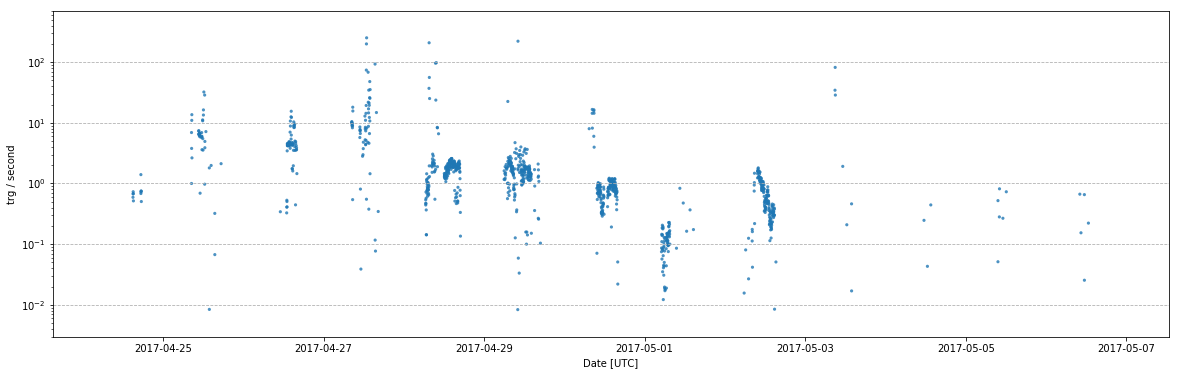

In [146]:
vis_trigger_rate(avg_trigger_datetime_steps_list, avg_trigger_num_per_step_list, None)

# Window size by file

In [192]:
processed_files[50:55]

['/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-123151-001.001--CHECK.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-123157-001.001--LONG.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-125006-001.001--CHECK.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-135111-001.001--CHECK.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-142402-001.001--CHECK.root']

In [138]:
def count_trigger_rate_per_file(processed_files_subset, data_snippets_dir, file_name_prefix='', recreate_pickles=False):
    
    processed_files_hash = hashlib.md5(pickle.dumps(processed_files_subset, protocol=0)).hexdigest()
    
    if data_snippets_dir is not None:
        trigger_num_per_file_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}_trigger_num_per_file.pkl'.format(processed_files_hash))
        trigger_rate_per_file_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}_trigger_rate_per_file.pkl'.format(processed_files_hash))
        file_trigger_datetimes_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}_file_trigger_datetimes.pkl'.format(processed_files_hash))
        file_trigger_timedelta_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}_file_trigger_timedelta.pkl'.format(processed_files_hash))
        file_trigger_p_r_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}_file_trigger_p_r.pkl'.format(processed_files_hash))
    else:
        recreate_pickles = True
    
    # {allpackets | events}-experiment-mode-date-time-bunch.bunchTot--comment.dat,
    # TODO bunch
    
    filename_type_re = re.compile(r'(\d+)\.(\d+)-+(LONG|CHECK)(-sqz)?\.root$')
    
    filename_datetime_re = re.compile(r'(\d{4})(\d\d)(\d\d)-(\d\d)(\d\d)(\d\d)-(\d+)\.(\d+)-+(LONG|CHECK)(-sqz)?\.root$')
        
    trigger_num_per_file_list = []
    trigger_rate_per_file_list = []
    file_trigger_datetimes_list = []
    file_timedelta_list = []
    file_trigger_p_r_list = []

    if recreate_pickles or False in [os.path.exists(f) for f in (
            trigger_num_per_file_list_pathname, trigger_rate_per_file_list_pathname, 
            file_trigger_datetimes_list_pathname, file_trigger_timedelta_list_pathname, file_trigger_p_r_list_pathname)]:
    
        last_p_r = None

        for j, infile in enumerate(sorted(processed_files_subset)):

            print('{:d}/{:d} {}'.format(j+1, len(processed_files_subset), infile))

            filename_type_m = filename_type_re.search(infile)
            if not filename_type_m:
                print(' > SKIPPING')
                continue
            
            if filename_type_m.group(3) == 'LONG':
                acq_timedelta = datetime.timedelta(seconds=120)
            elif filename_type_m.group(3) == 'CHECK':
                acq_timedelta = datetime.timedelta(seconds=40)

            bunch = int(filename_type_m.group(1))
            
            if bunch < 1:
                print(' > SKIPPING (bunch < 1)')
                continue
            
            #####
                
            file_last_frame_gtu_datetime = None
            file_first_frame_gtu_datetime = None
            
            file_last_frame_gtu_datetime__gps_datetime = None
            file_first_frame_gtu_datetime__gps_datetime = None
            
            file_last_frame_gps_datetime = None
            file_first_frame_gps_datetime = None                
                
            ####
                
            trigger_num_per_step = 0

            first_p_r = None
            last_p_r = None

            with event_reading.AcqL1EventReader(
                    infile, None, load_pdm_event_summary=True, parse_pdm_event_summary=False) as aer:

                if aer.tevent_entries <= 0:
                    print(' > no tevent entries')
                
#                 print(' > 1: ', len(aer.exp_tree.tree.run_date))
#                 print(' > 2: ', len(aer.exp_tree.tree.run_date[:-1]))
                
                if len(aer.exp_tree.tree.run_date[:-1]) == 0:
                    print(' > EMPTY exp_tree.run_date')
                    
                    m = filename_datetime_re.search(infile)
                    if m:
                        exp_tree_run_date_datetime = datetime.datetime(
                            year=int(m.group(1)), month=int(m.group(2)), day=int(m.group(3)), 
                            hour=int(m.group(4)), minute=int(m.group(5)), second=int(m.group(6))
                        )
                        print(' >> extracted from filename: ' + str(exp_tree_run_date_datetime))
                        
                    else:
                        print(' >> unable to extract datetime from filename')
                        continue
                    
                else:
                    exp_tree_run_date_datetime = datetime.datetime.strptime(aer.exp_tree.tree.run_date[:-1], '%a %b %d %H:%M:%S %Y')

                exp_tree_run_date_datetime_modified = exp_tree_run_date_datetime + acq_timedelta*(bunch-1)
                    
#                 print(' >> RAW aer.exp_tree.tree.run_date: ' + str(aer.exp_tree.tree.run_date))
                                                                    
                for i, gtu_pdm_data in enumerate(aer.iter_gtu_pdm_data()):
#                     if i==0:
#                         print(' >> (first frame) gtu_pdm_data.gtu_datetime =', gtu_pdm_data.gtu_datetime)
#                         print(' >> (first frame) gtu_pdm_data.gps_datetime =', gtu_pdm_data.gps_datetime)
                    
                    p_r = (aer._tevent_event_p_val.item(), aer._tevent_event_r_val.item())

                    if np.count_nonzero(aer._tevent_event_trig_counts) > 0:
                        trigger_num_per_step += 1

                        if first_p_r is None:
                            first_p_r = p_r
                        last_p_r = p_r

                    if file_first_frame_gtu_datetime__gps_datetime is None or file_first_frame_gtu_datetime__gps_datetime > gtu_pdm_data.gps_datetime:
                        file_first_frame_gtu_datetime__gps_datetime = gtu_pdm_data.gps_datetime
                    if file_last_frame_gtu_datetime__gps_datetime is None or file_last_frame_gtu_datetime__gps_datetime < gtu_pdm_data.gps_datetime:
                        file_last_frame_gtu_datetime__gps_datetime = gtu_pdm_data.gps_datetime
    
                    if file_first_frame_gtu_datetime is None or file_first_frame_gtu_datetime > gtu_pdm_data.gtu_datetime:
                        file_first_frame_gtu_datetime = gtu_pdm_data.gtu_datetime
                    if file_last_frame_gtu_datetime is None or file_last_frame_gtu_datetime < gtu_pdm_data.gtu_datetime:
                        file_last_frame_gtu_datetime = gtu_pdm_data.gtu_datetime

                    if file_first_frame_gps_datetime is None or file_first_frame_gps_datetime > gtu_pdm_data.gps_datetime:
                        file_first_frame_gps_datetime = gtu_pdm_data.gps_datetime
                    if file_last_frame_gps_datetime is None or file_last_frame_gps_datetime < gtu_pdm_data.gps_datetime:
                        file_last_frame_gps_datetime = gtu_pdm_data.gps_datetime    
                                               
#                 print(' >> exp_tree_run_date_datetime:         ' + str(exp_tree_run_date_datetime))
#                 print(' >> exp_tree_run_date_datetime + delta: ' + str(exp_tree_run_date_datetime + acq_timedelta))
#                 print(' >> exp_tree_run_date_datetime + delta*(bunch-1): ' + str(exp_tree_run_date_datetime + acq_timedelta*(bunch-1)))
#                 print(' >> exp_tree_run_date_datetime + delta*(bunch): ' + str(exp_tree_run_date_datetime + acq_timedelta*bunch))
                
#                 print(' >> file_first_frame_gtu_datetime =', file_first_frame_gtu_datetime)
#                 print(' >> file_last_frame_gtu_datetime =', file_last_frame_gtu_datetime)
#                 print(' >>>> diff =', file_last_frame_gtu_datetime - file_first_frame_gtu_datetime)
#                 print(' >> file_first_frame_gtu_datetime__gps_datetime =', file_first_frame_gtu_datetime__gps_datetime)
#                 print(' >> file_last_frame_gtu_datetime__gps_datetime =', file_last_frame_gtu_datetime__gps_datetime)
#                 print(' >>>> diff =', file_last_frame_gtu_datetime__gps_datetime - file_first_frame_gtu_datetime__gps_datetime)
#                 print(' >> file_first_frame_gps_datetime =', file_first_frame_gps_datetime)
#                 print(' >> file_last_frame_gps_datetime =', file_last_frame_gps_datetime)
#                 print(' >>>> diff =', file_last_frame_gps_datetime - file_first_frame_gps_datetime)
                
                if first_p_r != last_p_r:
                    print(' > P,R changed in a single file: P={}, R={} -> P={}, R={}'.format(first_p_r, last_p_r))
                    
            if trigger_num_per_step > 0:
                file_trigger_p_r_list.append(first_p_r)
                trigger_num_per_file_list.append(trigger_num_per_step)
                file_trigger_datetimes_list.append(exp_tree_run_date_datetime_modified)
                trigger_rate_per_file_list.append(trigger_num_per_step / acq_timedelta.total_seconds())
                file_timedelta_list.append(acq_timedelta.total_seconds())

        if data_snippets_dir is not None:
            joblib.dump(trigger_num_per_file_list, trigger_num_per_file_list_pathname)
            joblib.dump(trigger_rate_per_file_list, trigger_rate_per_file_list_pathname)
            joblib.dump(file_trigger_datetimes_list, file_trigger_datetimes_list_pathname)
            joblib.dump(file_trigger_p_r_list, file_trigger_p_r_list_pathname)
            joblib.dump(file_timedelta_list, file_trigger_timedelta_list_pathname)
    
    else:
        trigger_num_per_file_list = joblib.load(trigger_num_per_file_list_pathname)
        trigger_rate_per_file_list = joblib.load(trigger_rate_per_file_list_pathname)
        file_trigger_datetimes_list = joblib.load(file_trigger_datetimes_list_pathname)
        file_trigger_p_r_list = joblib.load(file_trigger_p_r_list_pathname)
        file_timedelta_list = joblib.load(file_trigger_timedelta_list_pathname)
        
    return file_trigger_datetimes_list, file_timedelta_list, file_trigger_p_r_list, trigger_num_per_file_list, trigger_rate_per_file_list

In [119]:
def vis_trigger_rate(trigger_datetime_steps_list, trigger_rate_steps_list, file_timedelta_list, file_trigger_p_r_list, 
                     figsize=(20, 6), base_figure_pathname=None, show=True, recreate_plots=True, 
                     padding_fraction=.10, ylabel='trg / second'):
    plt_xlim = (np.min(trigger_datetime_steps_list) - datetime.timedelta(days=1), 
                 np.max(trigger_datetime_steps_list) + datetime.timedelta(days=1))

    plt.figure(figsize=figsize)
    
    plt.scatter(trigger_datetime_steps_list, 
                trigger_rate_steps_list, 
                s=10, alpha=.8,
    #             alpha=.01,
                cmap=plt.get_cmap('plasma'),
                marker='o', edgecolors='none',
                label='Num triggers per second'
               )
    
    
    ylim_min = np.min(trigger_rate_steps_list)
    ylim_max = np.max(trigger_rate_steps_list)
    
    print(ylim_min, ylim_max)
    
    log10_ylim_max = np.log10(ylim_max)
    log10_ylim_min = np.log10(ylim_min)
    
    print(log10_ylim_min, log10_ylim_max)
    
    ylim_padding = (log10_ylim_max - log10_ylim_min) * padding_fraction
    print(ylim_padding)
    
    ylim_min = 10**(log10_ylim_min - ylim_padding)
    ylim_max = 10**(log10_ylim_max + ylim_padding)
    
    print(ylim_min, ylim_max)
    
    plt.ylim(ylim_min, ylim_max)
    
    plt.xlim(*plt_xlim)
    
    plt.yscale('log')
    # plt.ylim(1e-1, np.max(trigger_num_per_step)+10)
    plt.xlabel('Date [UTC]')
    plt.ylabel(ylabel)
    plt.gca().grid(which='major', axis='y', linestyle='--')

    if file_trigger_p_r_list is not None:
        
    
    if base_figure_pathname:
        trigger_rate_scatter_pathname = base_figure_pathname + '_scatter.png'
        if not os.path.exists(trigger_rate_scatter_pathname) or recreate_plots:
            plt.savefig(trigger_rate_scatter_pathname, dpi=150)
  
    if show:
        plt.show()

In [140]:
file_trigger_datetime_list, file_timedelta_list, file_trigger_p_r_list, trigger_num_per_file_list, file_trigger_rate_list = \
    count_trigger_rate_per_file(processed_files, data_snippets_dir)
#     count_trigger_rate_per_file(processed_files[128:138], data_snippets_dir=None)
#     count_trigger_rate_per_file(processed_files[137:138], data_snippets_dir=None)    

In [141]:
# file_trigger_datetime_list, trigger_num_per_file_list, file_trigger_rate_list, file_trigger_p_r_list = \
#     count_trigger_rate_per_file(processed_files[137:138], data_snippets_dir=None)

In [142]:
hashlib.md5(pickle.dumps(processed_files, protocol=0)).hexdigest()

'0359ed3b8091809b70ce45f5e2cd3f40'

1 29590
0.0 4.471144965160633
0.44711449651606333
0.3571786598807836 82843.69511290595


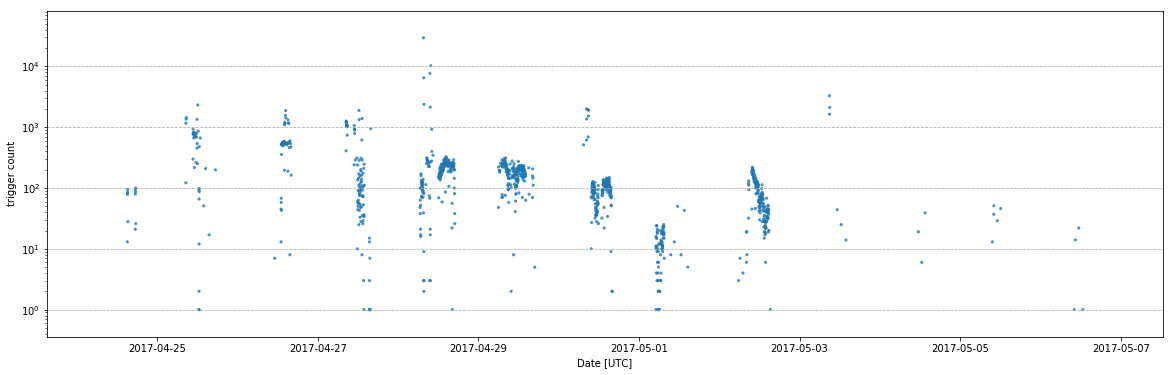

In [143]:
vis_trigger_rate(file_trigger_datetime_list, trigger_num_per_file_list, file_trigger_p_r_list, ylabel="trigger count")

0.008333333333333333 246.58333333333334
-2.079181246047625 2.3919637191130083
0.44711449651606333
0.0029764888323398613 690.3641259408839


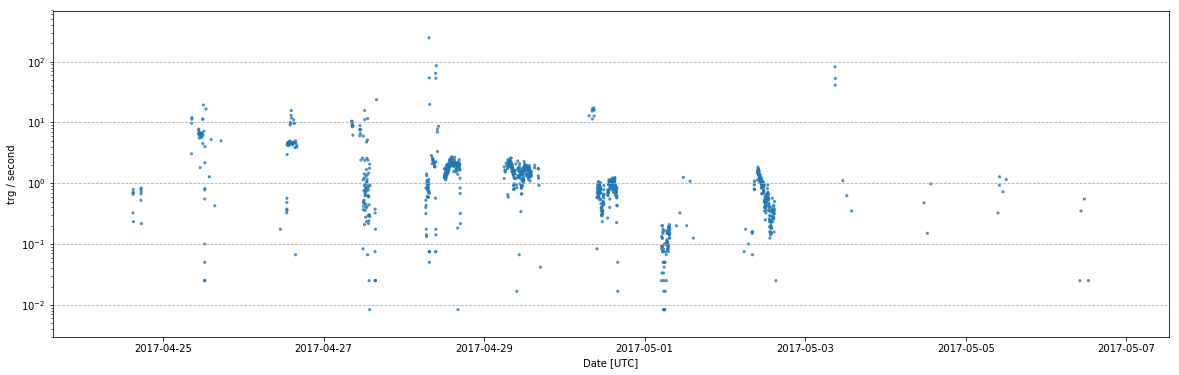

In [144]:
vis_trigger_rate(file_trigger_datetime_list, file_trigger_rate_list, file_trigger_p_r_list)